Libraries

In [274]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import joblib

sns.set(style='whitegrid')


Data loading

In [275]:

df = pd.read_excel("../data/Copy of loan.xlsx")
df.head()


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


initial Inspection

In [276]:
print(df.shape)

(614, 13)


In [277]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [278]:

df.describe().T

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,592.0,146.412162,85.587325,9.0,100.0,128.0,168.00,700.0
Loan_Amount_Term,600.0,342.000000,65.120410,12.0,360.0,360.0,360.00,480.0
Credit_History,564.0,0.842199,0.364878,0.0,1.0,1.0,1.00,1.0


Text(0.5, 1.0, 'Log Transformed Loan Amount Distribution')

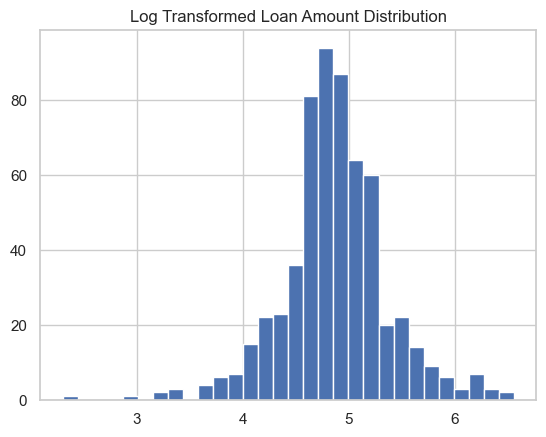

In [279]:
df['LoanAmount_log'] = np.log1p(df['LoanAmount'])
df['LoanAmount_log'].hist(bins=30)
plt.title('Log Transformed Loan Amount Distribution')

Data Cleaning and Pre-processing

In [280]:

df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
LoanAmount_log       22
dtype: int64

In [281]:
df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])
df['Married'] = df['Married'].fillna(df['Married'].mode()[0])
df['Self_Employed'] = df['Self_Employed'].fillna(df['Self_Employed'].mode()[0])
df['Dependents'] = df['Dependents'].fillna(df['Dependents'].mode()[0])

df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].mean())
df['LoanAmount_log'] = df['LoanAmount_log'].fillna(df['LoanAmount_log'].mean())

df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0])
df['Credit_History'] = df['Credit_History'].fillna(df['Credit_History'].mode()[0])

df.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
LoanAmount_log       0
dtype: int64

In [282]:
x = df.iloc[:, np.r_[1:5, 6:11, 13:14]].values
y = df.iloc[:, 12].values

x

array([['Male', 'No', 0, ..., 360.0, 1.0, 4.866324565936641],
       ['Male', 'Yes', 1, ..., 360.0, 1.0, 4.859812404361672],
       ['Male', 'Yes', 0, ..., 360.0, 1.0, 4.204692619390966],
       ...,
       ['Male', 'Yes', 1, ..., 360.0, 1.0, 5.537334267018537],
       ['Male', 'Yes', 2, ..., 360.0, 1.0, 5.236441962829949],
       ['Female', 'No', 0, ..., 360.0, 0.0, 4.897839799950911]],
      shape=(614, 10), dtype=object)

In [283]:
print("per of missing gender is %.2f%%" % ((df['Gender'].isnull().sum() / df.shape[0]) * 100))


per of missing gender is 0.00%


Number of people who take loan grouped by gender:
Gender
Male      502
Female    112
Name: count, dtype: int64


<Axes: xlabel='Gender', ylabel='count'>

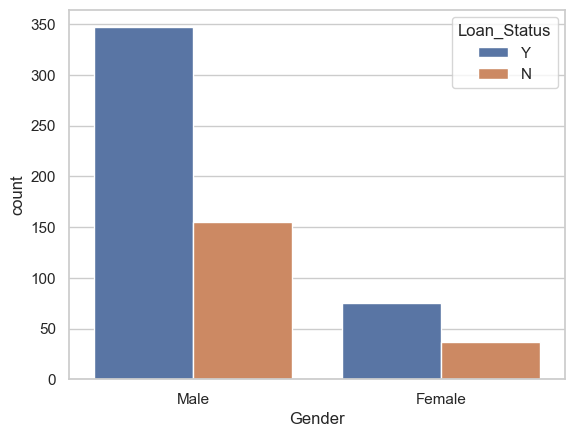

In [284]:
print("Number of people who take loan grouped by gender:")
print(df['Gender'].value_counts())

sns.countplot(x='Gender', data=df, hue='Loan_Status')


Number of people who take loan grouped by marital status:
Married
Yes    401
No     213
Name: count, dtype: int64


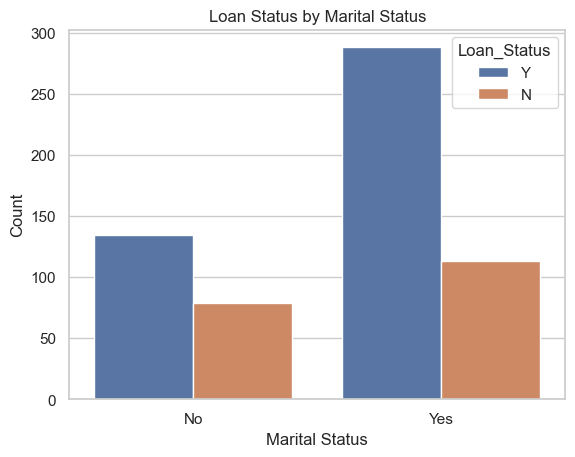

In [285]:
print("Number of people who take loan grouped by marital status:")
print(df['Married'].value_counts())

sns.countplot(x='Married', data=df, hue='Loan_Status')
plt.title("Loan Status by Marital Status")
plt.xlabel("Marital Status")
plt.ylabel("Count")
plt.show()


Number of people who take loan grouped by Dependancy:
Dependents
0     360
1     102
2     101
3+     51
Name: count, dtype: int64


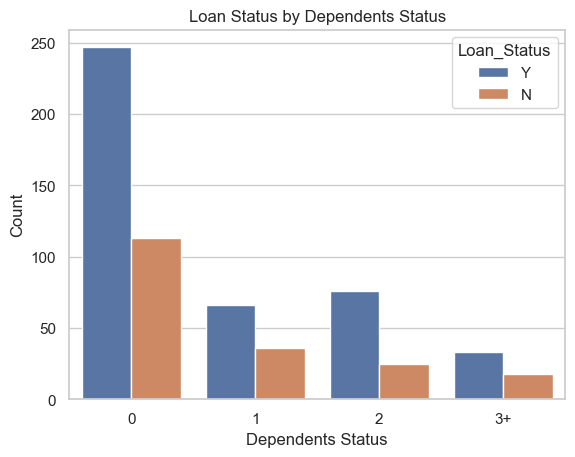

In [286]:
print("Number of people who take loan grouped by Dependancy:")
print(df['Dependents'].value_counts())

sns.countplot(x='Dependents', data=df, hue='Loan_Status')
plt.title("Loan Status by Dependents Status")
plt.xlabel("Dependents Status")
plt.ylabel("Count")
plt.show()


Number of people who take loan grouped by Self_Employed:
Self_Employed
No     532
Yes     82
Name: count, dtype: int64


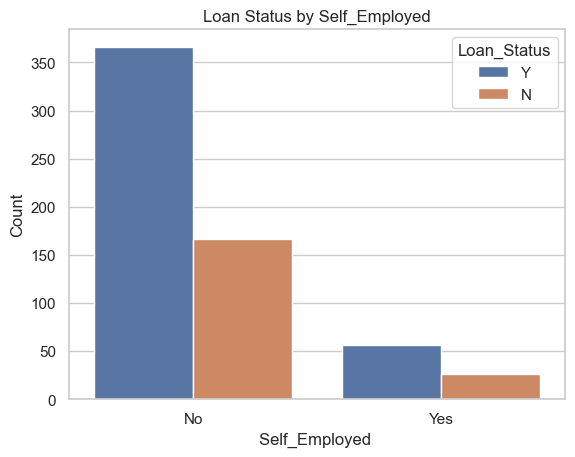

In [287]:
print("Number of people who take loan grouped by Self_Employed:")
print(df['Self_Employed'].value_counts())

sns.countplot(x='Self_Employed', data=df, hue='Loan_Status')
plt.title("Loan Status by Self_Employed")
plt.xlabel("Self_Employed ")
plt.ylabel("Count")
plt.show()

number of people who take loan as group by loan amount:
LoanAmount
146.412162    22
120.000000    20
110.000000    17
100.000000    15
187.000000    12
              ..
292.000000     1
142.000000     1
350.000000     1
496.000000     1
253.000000     1
Name: count, Length: 204, dtype: int64


C:\Users\Dell\AppData\Local\Temp\ipykernel_16240\56286228.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='LoanAmount', data=df, palette='Set1')


<Axes: xlabel='LoanAmount', ylabel='count'>

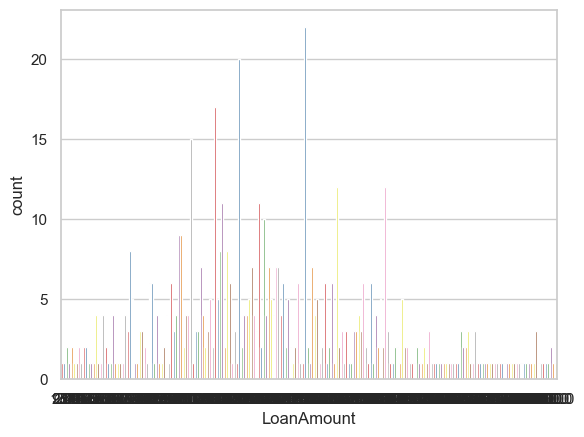

In [288]:
print("number of people who take loan as group by loan amount:")
print(df['LoanAmount'].value_counts())
sns.countplot(x='LoanAmount', data=df, palette='Set1')

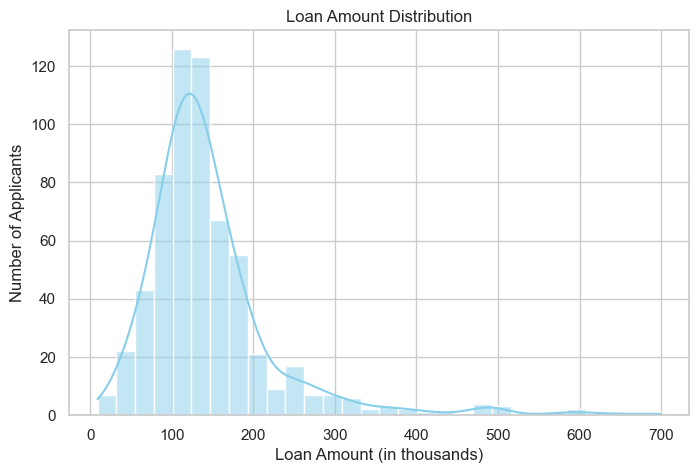

In [289]:
plt.figure(figsize=(8,5))
sns.histplot(df['LoanAmount'], bins=30, kde=True, color='skyblue')
plt.title("Loan Amount Distribution")
plt.xlabel("Loan Amount (in thousands)")
plt.ylabel("Number of Applicants")
plt.show()


In [290]:
df.columns = df.columns.str.strip()


Number of people who take loan grouped by Credit History:
Credit_History
1.0    525
0.0     89
Name: count, dtype: int64


C:\Users\Dell\AppData\Local\Temp\ipykernel_16240\2792823178.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Credit_History', data=df, palette='Set1')


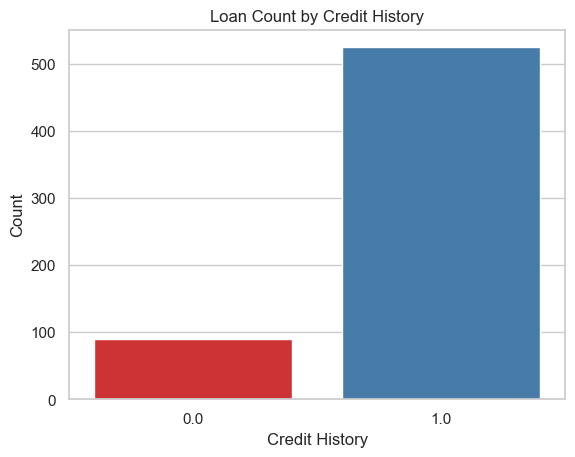

In [291]:
print("Number of people who take loan grouped by Credit History:")
print(df['Credit_History'].value_counts())

sns.countplot(x='Credit_History', data=df, palette='Set1')
plt.title("Loan Count by Credit History")
plt.xlabel("Credit History")
plt.ylabel("Count")
plt.show()


In [292]:
df['Dependents'] = pd.to_numeric(df['Dependents'].replace('3+', 3))

C:\Users\Dell\AppData\Local\Temp\ipykernel_16240\2245238331.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Dependents'] = pd.to_numeric(df['Dependents'].replace('3+', 3))


Feature Engineering

<Axes: >

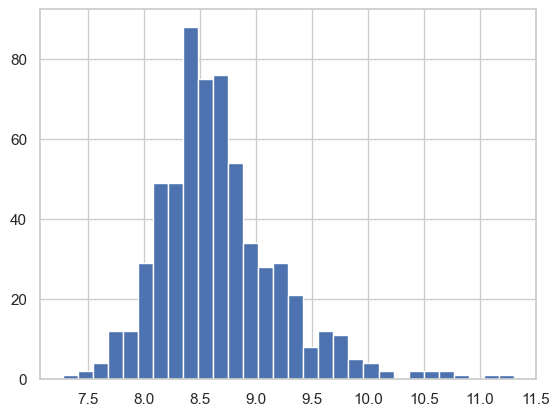

In [293]:

df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['TotalIncome_log'] = np.log(df['TotalIncome'])
df['TotalIncome_log'].hist(bins=30)


In [294]:
# Log-transform numerical features to handle skewness
df['ApplicantIncome_log'] = np.log(df['ApplicantIncome'])
df['CoapplicantIncome_log'] = np.log(df['CoapplicantIncome'] + 1) 
df['LoanAmount_log'] = np.log(df['LoanAmount'])
df['Loan_Amount_Term_log'] = np.log(df['Loan_Amount_Term'])
df['TotalIncome_log'] = np.log(df['TotalIncome'])

In [295]:

df.drop(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'TotalIncome'], axis=1, inplace=True)

Label Encode the Target Variable

In [296]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Loan_Status'] = le.fit_transform(df['Loan_Status'])

Data splitting

In [299]:
x = df.drop(['Loan_ID', 'Loan_Status'], axis=1)
y = df['Loan_Status']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [301]:
from sklearn.preprocessing import LabelEncoder

LabelEncoder_x = LabelEncoder()

for i in (0, 5):
    x_train.iloc[:, i] = LabelEncoder_x.fit_transform(x_train.iloc[:, i].astype(str))

x_train.iloc[:, 7] = LabelEncoder_x.fit_transform(x_train.iloc[:, 7].astype(str))


    

In [302]:
LabelEncoder_y = LabelEncoder()
y_train = LabelEncoder_y.fit_transform(y_train)

y_train

array([0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,

In [304]:
from sklearn.preprocessing import LabelEncoder

LabelEncoder_x = LabelEncoder()

for i in range(0, 5):
    x_test.iloc[:, i] = LabelEncoder_x.fit_transform(x_test.iloc[:, i].astype(str))

x_test.iloc[:, 7] = LabelEncoder_x.fit_transform(x_test.iloc[:, 7].astype(str))


In [ ]:
LabelEncoder_y = LabelEncoder()
y_test = LabelEncoder_y.fit_transform(y_test)
y_test

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1])

In [305]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)


ValueError: could not convert string to float: 'Yes'

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()
rf_clf.fit(x_train, y_train)

RandomForestClassifier()

In [ ]:
from sklearn import metrics

y_pred = rf_clf.predict(x_test)
accuracy = metrics.accuracy_score(y_test, y_pred) 
print('Accuracy of Random Forest Classifier is {:.2%}'.format(accuracy))

y_pred

Accuracy of Random Forest Classifier is 77.24%


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb_clf = GaussianNB()
nb_clf.fit(x_train, y_train)

GaussianNB()

In [ ]:
from sklearn import metrics

y_pred = nb_clf.predict(x_test)
accuracy = metrics.accuracy_score(y_test, y_pred) 

print('Accuracy of GaussianNB is {:.2%}'.format(accuracy))
y_pred


Accuracy of GaussianNB is 78.05%


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier()
dt_clf.fit(x_train, y_train)

DecisionTreeClassifier()

In [ ]:
y_pred = dt_clf.predict(x_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy of DT is {:.2%}'.format(accuracy))
y_pred



Accuracy of DT is 67.48%


array([1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0])

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

kn_clf = KNeighborsClassifier()
kn_clf.fit(x_train, y_train)

KNeighborsClassifier()

In [ ]:
y_pred = kn_clf.predict(x_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy of knn is {:.2%}'.format(accuracy))
y_pred

Accuracy of knn is 73.17%


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1])